In [28]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")

In [29]:
# Skip date
df1 = pd.read_csv('C:/Users/SIMRAN/Desktop/data/testcombined/combined.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::1, :])

Dataset 1 shape: (272, 2)
-Dataset examples-
     Cust_Id  Rating
0         1:     NaN
1    1488844     3.0
2     822109     5.0
3     885013     4.0
4      30878     4.0
5     823519     3.0
6     893988     3.0
7     124105     4.0
8    1248029     3.0
9    1842128     4.0
10   2238063     3.0
11   1503895     4.0
12   2207774     5.0
13   2590061     3.0
14      2442     3.0
15    543865     4.0
16   1209119     4.0
17    804919     4.0
18   1086807     3.0
19   1711859     4.0
20    372233     5.0
21    712664     5.0
22   1331154     4.0
23   2632461     5.0
24    712664     1.0
25   1331154     1.0
26   2632461     1.0
27         6     3.0
28       383     5.0
29       311     5.0
..       ...     ...
242      517     4.0
243      533     3.0
244      390     4.0
245       93     4.0
246      535     4.0
247      569     4.0
248       18     5.0
249       81     4.0
250      293     2.0
251       6:     NaN
252       43     4.0
253      291     4.0
254      157     4.0
255      1

In [42]:
# # load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::1, :])

Full dataset shape: (272, 2)
-Dataset examples-
     Cust_Id  Rating
0         1:     NaN
1    1488844     3.0
2     822109     5.0
3     885013     4.0
4      30878     4.0
5     823519     3.0
6     893988     3.0
7     124105     4.0
8    1248029     3.0
9    1842128     4.0
10   2238063     3.0
11   1503895     4.0
12   2207774     5.0
13   2590061     3.0
14      2442     3.0
15    543865     4.0
16   1209119     4.0
17    804919     4.0
18   1086807     3.0
19   1711859     4.0
20    372233     5.0
21    712664     5.0
22   1331154     4.0
23   2632461     5.0
24    712664     1.0
25   1331154     1.0
26   2632461     1.0
27         6     3.0
28       383     5.0
29       311     5.0
..       ...     ...
242      517     4.0
243      533     3.0
244      390     4.0
245       93     4.0
246      535     4.0
247      569     4.0
248       18     5.0
249       81     4.0
250      293     2.0
251       6:     NaN
252       43     4.0
253      291     4.0
254      157     4.0
255    

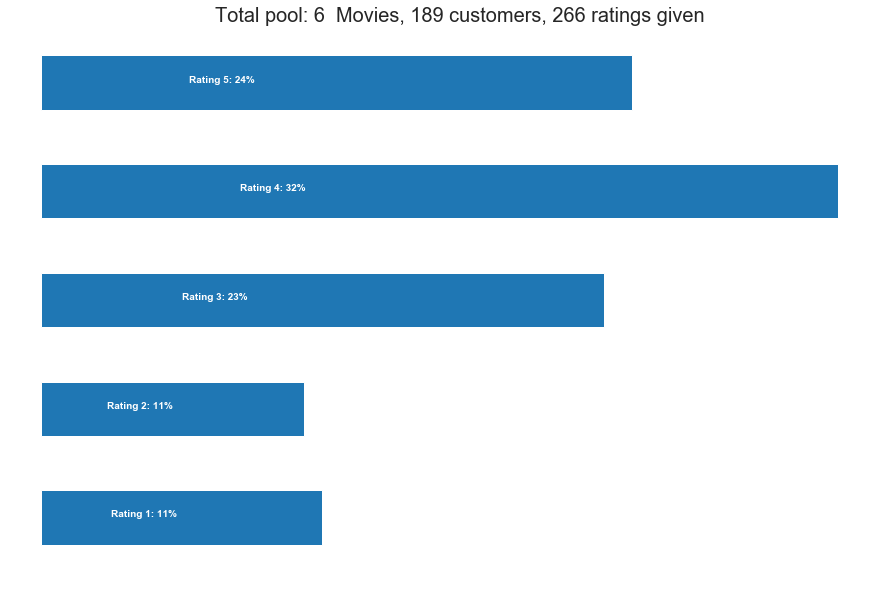

In [44]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,}  Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [45]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6.]
Length: 266


In [46]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::1, :])

-Dataset examples-
     Cust_Id  Rating  Movie_Id
1    1488844     3.0         1
2     822109     5.0         1
3     885013     4.0         1
4      30878     4.0         1
5     823519     3.0         1
6     893988     3.0         1
7     124105     4.0         1
8    1248029     3.0         1
9    1842128     4.0         1
10   2238063     3.0         1
11   1503895     4.0         1
12   2207774     5.0         1
13   2590061     3.0         1
14      2442     3.0         1
15    543865     4.0         1
16   1209119     4.0         1
17    804919     4.0         1
18   1086807     3.0         1
19   1711859     4.0         1
20    372233     5.0         1
21    712664     5.0         1
22   1331154     4.0         1
23   2632461     5.0         1
24    712664     1.0         1
25   1331154     1.0         1
26   2632461     1.0         1
27         6     3.0         1
28       383     5.0         1
29       311     5.0         1
30         1     5.0         1
..       ...     ...

C:\Users\SIMRAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\SIMRAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [47]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.0),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.0),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 20.0
Customer minimum times of review: 1.0


In [48]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::1, :])

Original Shape: (266, 3)
After Trim Shape: (266, 3)
-Data Examples-
     Cust_Id  Rating  Movie_Id
1    1488844     3.0         1
2     822109     5.0         1
3     885013     4.0         1
4      30878     4.0         1
5     823519     3.0         1
6     893988     3.0         1
7     124105     4.0         1
8    1248029     3.0         1
9    1842128     4.0         1
10   2238063     3.0         1
11   1503895     4.0         1
12   2207774     5.0         1
13   2590061     3.0         1
14      2442     3.0         1
15    543865     4.0         1
16   1209119     4.0         1
17    804919     4.0         1
18   1086807     3.0         1
19   1711859     4.0         1
20    372233     5.0         1
21    712664     5.0         1
22   1331154     4.0         1
23   2632461     5.0         1
24    712664     1.0         1
25   1331154     1.0         1
26   2632461     1.0         1
27         6     3.0         1
28       383     5.0         1
29       311     5.0         1
30

In [49]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(189, 6)


In [50]:
df_title = pd.read_csv('C:/Users/SIMRAN/Desktop/data/testcombined/combined_title.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

          Year                          Name
Movie_Id                                    
1         2003               Dinosaur Planet
2         2004    Isle of Man TT 2004 Review
3         1997                     Character
4         1994  Paula Abdul's Get Up & Dance
5         2004      The Rise and Fall of ECW
6         1998                       Tin Cup


In [51]:
print(df_p)

Movie_Id    1    2    3    4    5    6
Cust_Id                               
1         5.0  NaN  5.0  NaN  NaN  NaN
2         NaN  NaN  3.0  3.0  5.0  NaN
6         3.0  NaN  NaN  NaN  NaN  NaN
11        NaN  NaN  NaN  NaN  NaN  3.0
18        4.0  NaN  4.0  NaN  5.0  NaN
21        NaN  3.0  NaN  NaN  NaN  NaN
23        NaN  NaN  NaN  NaN  4.0  NaN
26        NaN  3.0  3.0  NaN  NaN  NaN
40        NaN  4.0  4.0  NaN  NaN  NaN
42        NaN  NaN  NaN  4.0  NaN  3.0
43        NaN  1.0  NaN  NaN  NaN  4.0
46        NaN  2.0  NaN  NaN  NaN  NaN
62        2.0  NaN  2.0  NaN  4.0  3.0
66        NaN  NaN  4.0  4.0  NaN  NaN
81        NaN  NaN  4.0  4.0  4.0  NaN
82        NaN  4.0  4.0  NaN  2.0  NaN
85        4.0  NaN  NaN  NaN  NaN  NaN
90        5.0  NaN  NaN  NaN  NaN  NaN
93        NaN  NaN  NaN  NaN  4.0  NaN
99        NaN  NaN  2.0  NaN  NaN  NaN
104       1.0  NaN  5.0  5.0  4.0  4.0
119       1.0  NaN  NaN  NaN  NaN  NaN
121       5.0  NaN  NaN  NaN  NaN  NaN
128       NaN  NaN  1.0  

In [52]:
def pcorr(movie_title):
    print("For movie ({})".format(movie_title))
    print("-Movie's Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target)

In [53]:
pcorr("Tin Cup")

For movie (Tin Cup)
-Movie's Pearsons'R correlation - 
          PearsonR                          Name  count      mean
Movie_Id                                                         
6         1.000000                       Tin Cup     20  3.050000
5         0.801784      The Rise and Fall of ECW     46  3.869565
4         0.039873  Paula Abdul's Get Up & Dance     51  3.039216
3        -0.075449                     Character     47  3.553191
1        -0.095130               Dinosaur Planet     50  3.680000
2        -0.534522    Isle of Man TT 2004 Review     52  3.384615
